# Visualizing Convolutional Neural Networks

*Code samples adapted from Francois Chollet:*
https://github.com/fchollet/deep-learning-with-python-notebooks/

*SMU Contributors: Ian Johnson, Eric C. Larson*

Deep learning models are frequently treated with a "black-box" mentality: users simply care about output and don't care to take a look inside to see what's going on. Since convolutional neural networks are, abstractly speaking, "representations of visual concepts" (Chollet), they are viable for visualization.

There are numerous ways to visualize the underlying structure and state of a CNN. Chollet explores 3 particularly useful and intuitive techniques for visualizing convolutional networks:
* Visualizing intermediate outputs / activations
* Visualizing convolutional filters
* Visualizing heatmaps of class activations in input images (for classification CNNs only)



### Loading a Model

The following visualization code is adapted from Chollet's Jupyter Notebooks for his book:
 https://github.com/fchollet/deep-learning-with-python-notebooks/

In [9]:
import keras
keras.__version__

from keras.models import load_model

model = load_model('models/cats_and_dogs_small_2.h5')
model.summary()  # As a reminder.

OSError: Unable to open file (unable to open file: name = 'models/cats_and_dogs_small_2.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Loading and Formatting an Image

Here we load an image to use for our visualization. Feel free to try an image of your own choosing.

In [10]:
img_url = 'https://raw.githubusercontent.com/8000net/LectureNotes/master/images/dog.jpg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np
import requests
from io import BytesIO
from PIL import Image

def load_image_as_array(url, size=(150, 150)):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(size)
    return np.array(img).astype(float)

img_tensor = load_image_as_array(img_url)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

(1, 150, 150, 3)


<Figure size 640x480 with 1 Axes>

# Visualizing Intermediate Activations

Given an arbitrary input to a CNN, we can visualize the activation of each layer of the network by displaying the feature maps that are output by each layer of the network. For each layer, there is a 3-dimensional feature map which can be visualized as a set of 2D images, one for each channel. The resulting images are representations of the filter activations of individual channels in a convolutional or pooling layer. Chollet uses the following example of a cat image to visualize the contents of a CNN used to descriminate between cats and dogs.


### Visualizing the Activation of a Channel

Now that we've loaded an image to visualize the network with, we can create a Model that accepts inputs of image batches and returns outputs of all the layers of the original network.

"To do this, we will use the Keras class Model. A Model is instantiated using two arguments: an input tensor (or list of input tensors), and an output tensor (or list of output tensors). The resulting class is a Keras model, just like the Sequential models that you are familiar with, mapping the specified inputs to the specified outputs. What sets the  Model class apart is that it allows for models with multiple outputs, unlike Sequential. For more information about the Model class, see Chapter 7, Section 1." (Chollet)

In [9]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

Notice that this is not a traditional Keras model in that there are multiple outputs. Generally speaking, Keras supports an arbitrary number of inputs and outputs to a model, but we have used one-input, one-output models up to this point.

In [10]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


### Visualizing a Single Channel

Using this multi-output model, we can visualize the activation of any arbitrary channel of any layer of the network. For example, here is a channel of the first layer that appears to function as a diagonal edge detector.

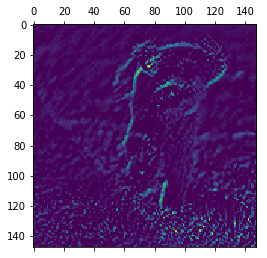

In [11]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 29], cmap='viridis')
plt.show()

This can be extended to visualize every channel of every layer in the network, which gives us eyes into the black box of the convolutional cats-and-dogs network. The following code (Chollet) plots every single channel side-by-side for each layer of the network.

### Visualizing the Entire Network's Activations

/hpc/applications/anaconda/3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


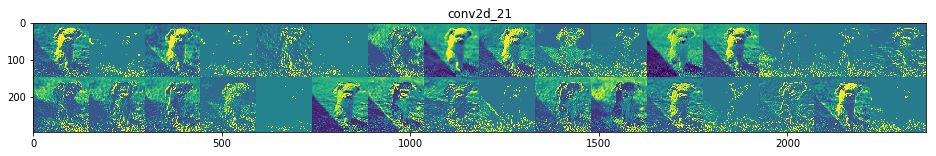

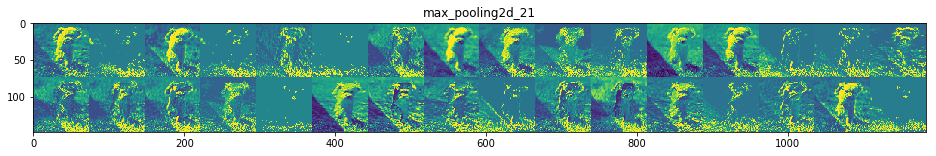

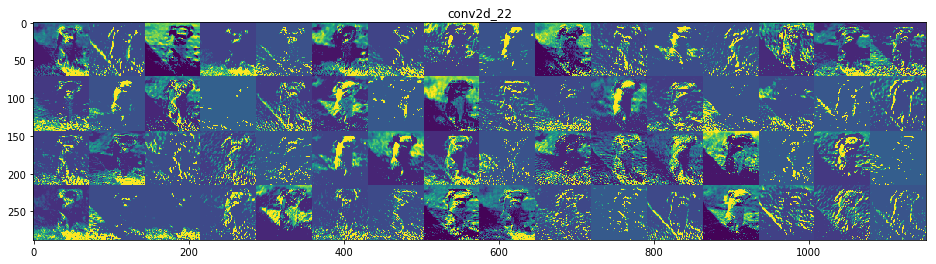

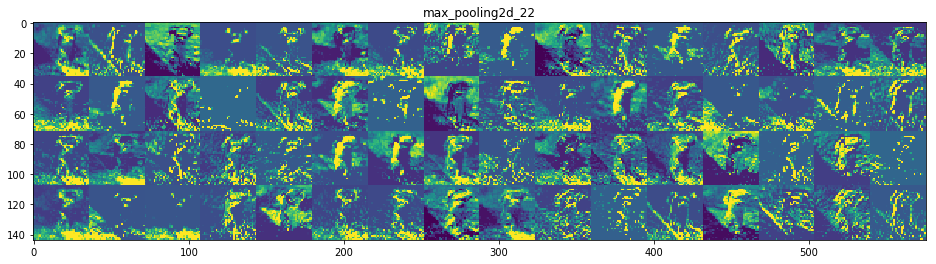

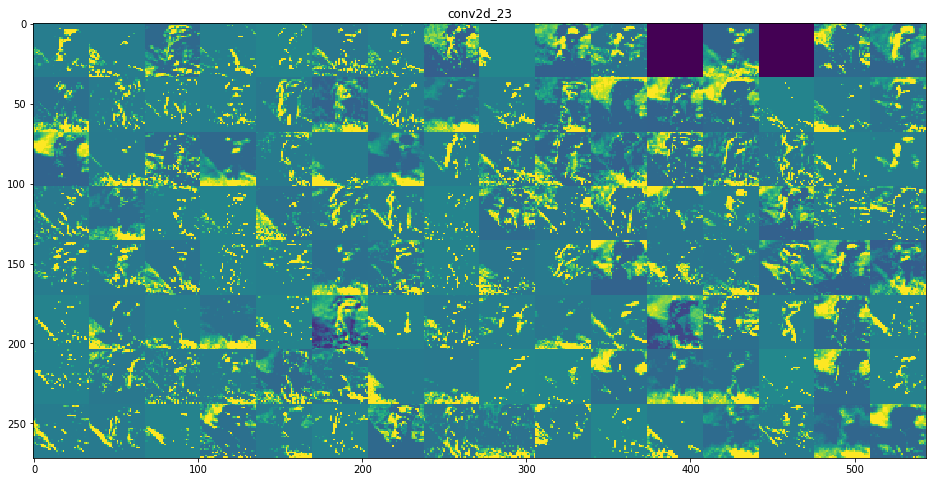

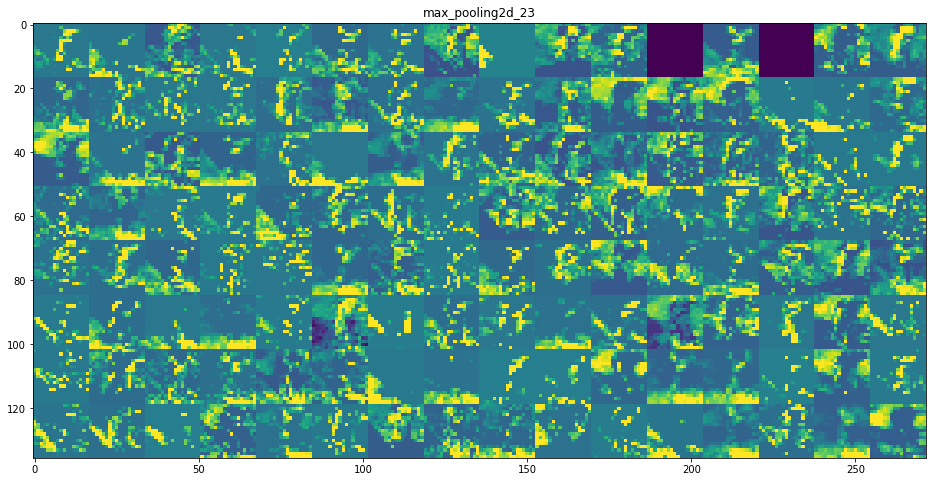

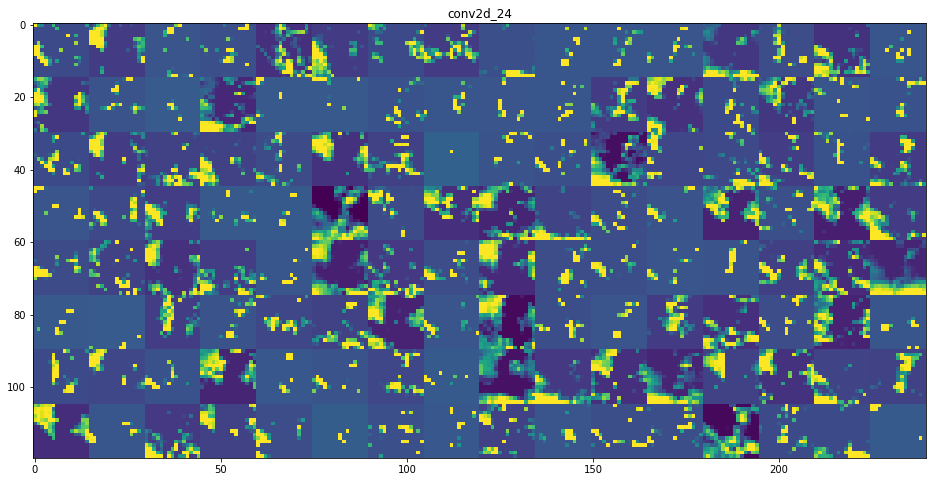

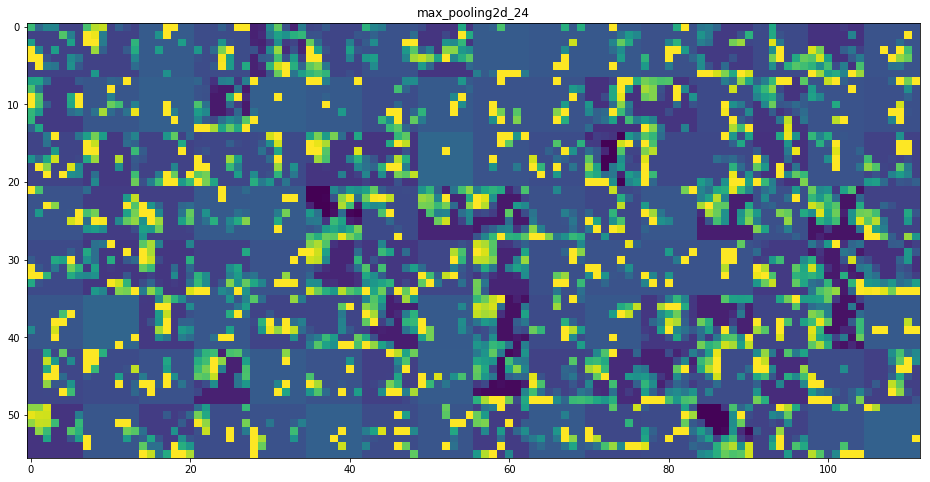

In [12]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

### Observations

Notice that as we move downward through this figure, into deeper layers of the network, the activations retain less and less of the original input content. The channels serve primarily as edge detectors and the like, while later layers retain very little of the original form of the image. Moreover, in some later layers, there is no activation. For example, in max_pooling2d_23, there are two channels with no activation. This indicates that the pattern represented by that channel is not present in the source image.

It is important to identify that, as you move deeper into the network, the features that activate a given channel become more and more abstract. Chollet describes this behaviour by comparing a convolutional neural network to an **information distillation pipeline**, which iteratively transforms raw data such that irrelevant information is "filtered out and useful information is magnified."

I encourage you to try your own image of a dog or cat and examine the activations with that image. Spend some time looking at what all the activations look like. Can you identify any high-level abstract concepts that are identified by later-level layers? Perhaps dog ears or cat eyes?

## Live Demo Activations.py
Now let's look at analyzing this through the WebCam for VGG. You can run the following scripts in python assuming you have OpenCV installed.

`cd activation-demo`

`python Activations.py`


# [Back to Slides]

___

# Visualizing Convolutional Filters in VGG16

We can also perform the inverse operation, in some sense, by synthesizing images to maximize the response from a specific filter. This allows us to visualize the pattern that a given channel responds to. This can be performed with gradient ascent, a process wherein you perform gradient descent on the input image to a network, starting with a blank image. The final result image, in an optimal gradient ascent, is maximally activating of the chosen filter.

Chollet performs this with the following code, which utliizes stochastic gradient descent to synthesize an image which maximally activates an arbitrary filter

In [1]:
from keras.applications import VGG16
from keras import backend as K

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=False)

# Selecting a layer and channel to visualize
layer_name = 'block3_conv1'
filter_index = 0
 
# Isolate the output and loss for the given chanel
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

# We take the gradient of this loss using keras backend.gradients
grads = K.gradients(loss, model.input)[0]

# Before performing gradient descent, we divide the gradient tensor by its L2 norm (square root
# of the mean of the square of values in the tensor). We add a small epsilon term to the L2 norm
# to avoid division by zero.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# We use a keras backend function to accept a numpy tensor and return a loss and gradient for that tensor.
iterate = K.function([model.input], [loss, grads])

# To quickly test the interface:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 7s 0us/step


When we perform gradient descent and iteratively update the blank image, the result is not guaranteed to be a valid, displayable image. We can fix that using a simple utility function below:

In [6]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### A Generic Function for Filter Activation Optimization

Using this deprocess_image utility function, and the code above, we can write a generalized function to generate an optimal image for activating any arbitrary filter in the network. Notice the additonal code at the bottom of the function which, for 40 iterations, performs gradient ascent on the input image to adjust it to maximize filter activation.

In [7]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### Visualizing a Single Filter

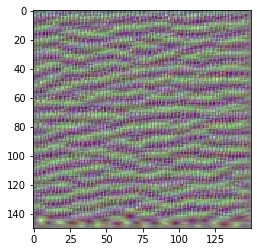

In [11]:
plt.imshow(generate_pattern('block3_conv1', 7))
plt.show()

### Visualizing the Entire Network's Filters

This can be repeated for any filter in the network. The following code from Chollet plots 64 of the filters from each convolutional layer, with black margins between them in 4 8x8 grids of filters. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


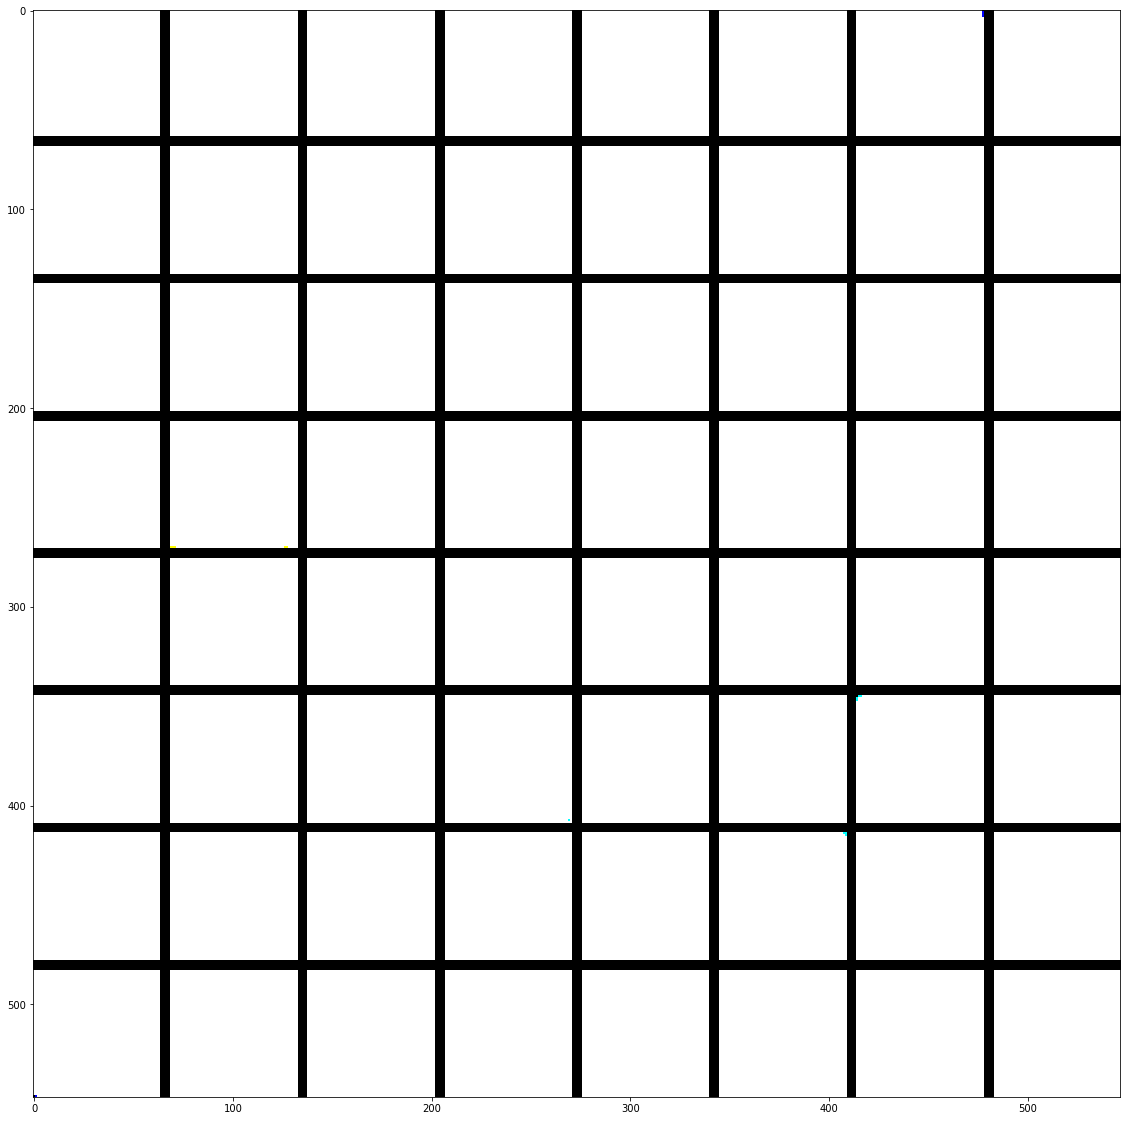

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


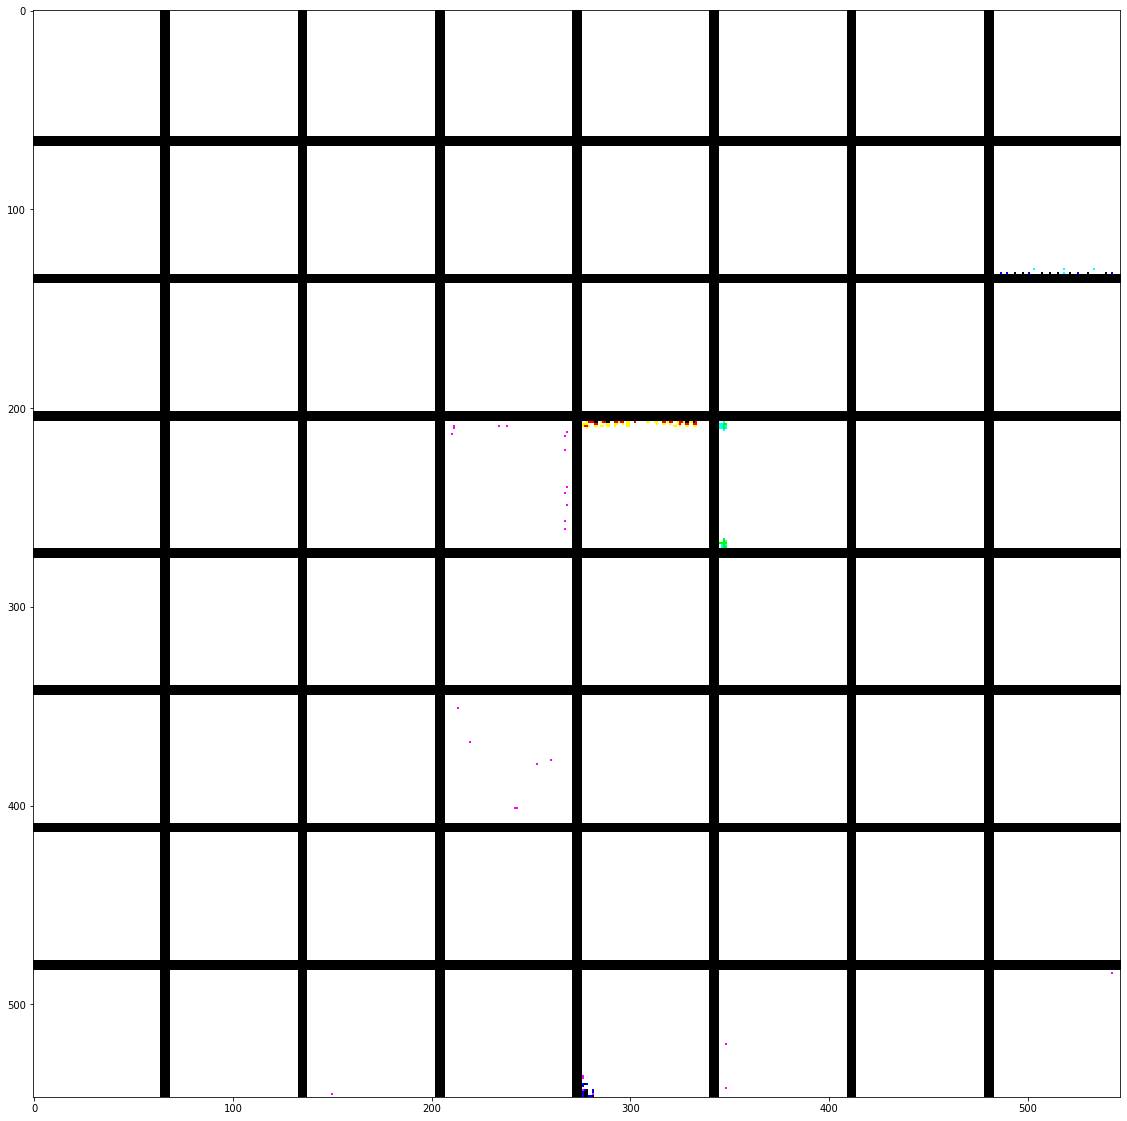

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


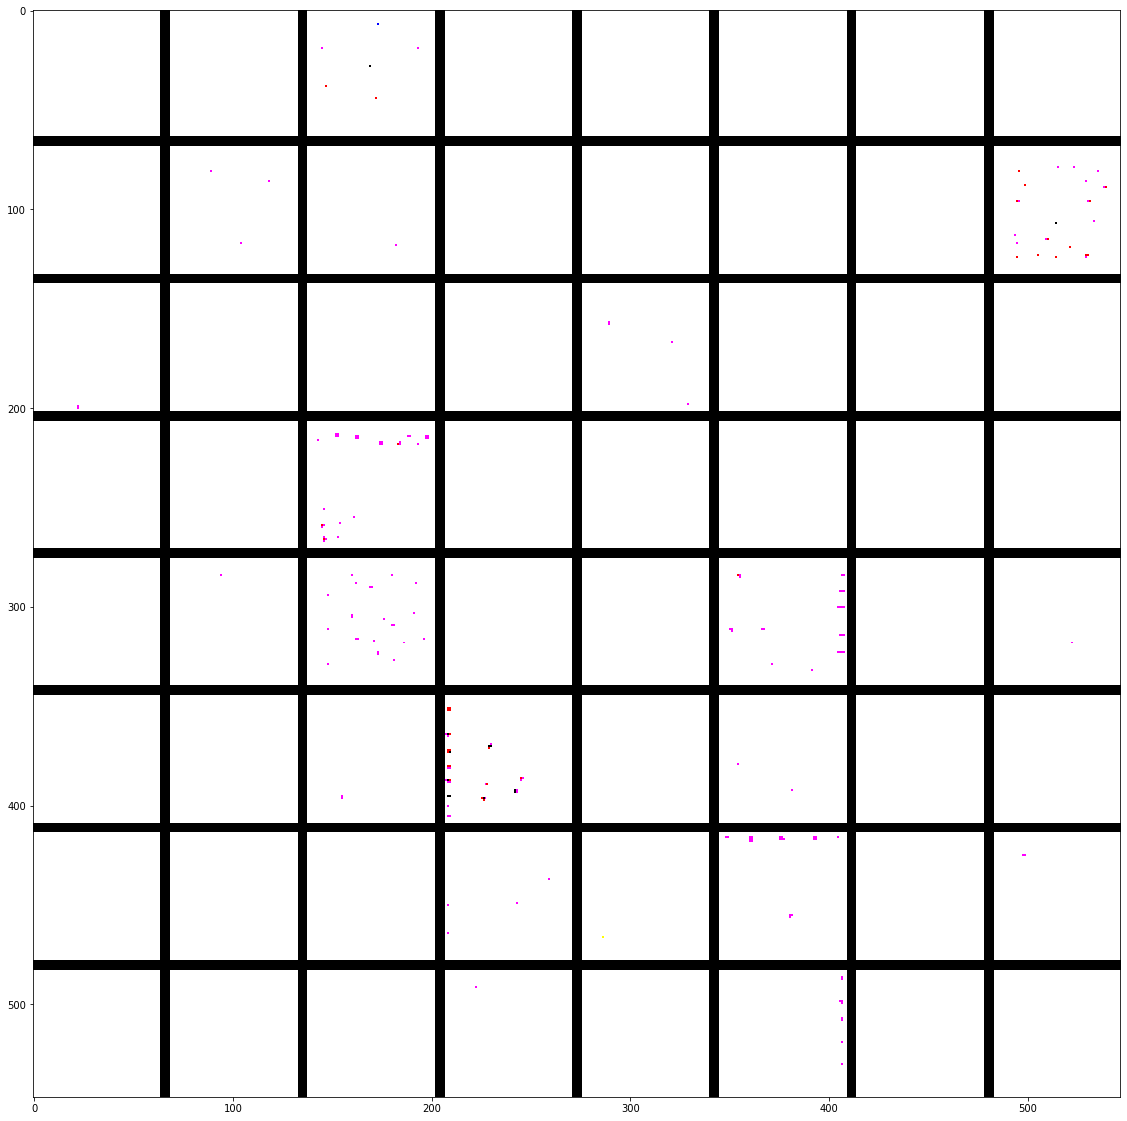

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


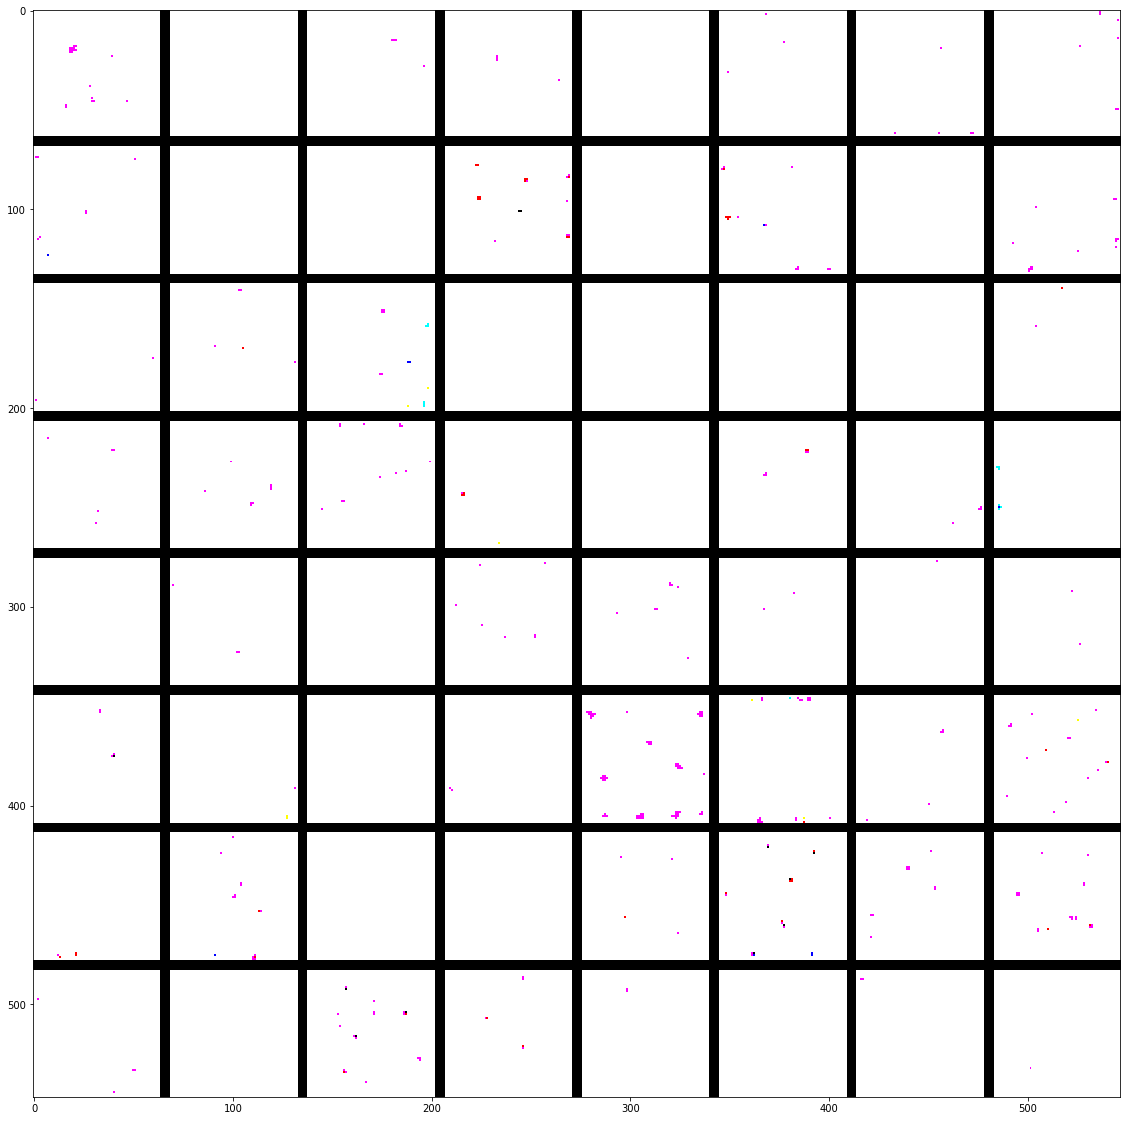

In [12]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

### Observations

Notice that the trend observed in the first set of visualizations is very evident here: as we move into deeper layers of the network, the convolutional filters resemble increasingly abstract ideas. The first layer consists of primarily simple textures, and the filters get increasingly complex until we reach the final layer, where filters have abstract meanings recognizable to the human eye (feathers, eyes, bricks, etc.)

### Going Beyond the Demo:
Now try to manipulate the above code to generate images like **DeepDream**. To achieve this:
- Implement a "random shift" process for adding noise into the image
- Implement L1 normalization of the gradient
- Implement clipping during the iteration process


# [Back To Slides]

___